# Notebook resumen
Para este proyecto de Machine Learning, hemos elegido un set de datos de Kaggle que contiene un ranking de los 100 repositorios de Python mas populares desde diciembre de 2018 hasta el inicio del trabajo en febrero de 2024. El objetivo es crear un modelo que prediga el número de forks que se realizan sobre un repostorio.

## Librerias

In [1]:
# Manejo de datos
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualización
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from matplotlib.ticker import FixedLocator, FixedFormatter

import seaborn as sns

# Preporcesado
from sklearn.preprocessing import LabelEncoder, RobustScaler

# Clusterinzación
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# Baselines y optimización
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Modelos
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor

# Metricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Vectorización
from sklearn.feature_extraction.text import CountVectorizer

# Regex
import re

# nlp
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import spacy
from collections import Counter

# Warnigs
import warnings
warnings.filterwarnings("ignore")

## Carga de datos

In [2]:
df = pd.read_csv("..\data\\raw\popular_python_projects.csv")

## Índice

1. EDA

2. Limpieza

3. Feature engeneering

4. Transformaciones y escalado

5. Clusterización

6. Modelo cluster 0

7. Modelo cluster 1

8. Modelo cluster 2

## 1. EDA

### Primera exploración

In [3]:
df.head()

,date,rank,item,repo_name,stars,forks,language,repo_url,username,issues,last_commit,description
0,2018-12-18,1,Python,awesome-python,58777,11448,Python,https://github.com/vinta/awesome-python,vinta,439,2018-12-13T08:29:32Z,"A curated list of awesome Python frameworks, l..."
1,2018-12-18,2,Python,system-design-primer,53575,7570,Python,https://github.com/donnemartin/system-design-p...,donnemartin,68,2018-12-18T11:20:56Z,Learn how to design large-scale systems. Prep ...
2,2018-12-18,3,Python,models,46039,28053,Python,https://github.com/tensorflow/models,tensorflow,1324,2018-12-18T02:29:33Z,Models and examples built with TensorFlow
3,2018-12-18,4,Python,public-apis,45373,4707,Python,https://github.com/toddmotto/public-apis,toddmotto,5,2018-12-18T11:24:53Z,A collective list of free APIs for use in soft...
4,2018-12-18,5,Python,youtube-dl,44956,7820,Python,https://github.com/rg3/youtube-dl,rg3,2566,2018-12-18T11:18:21Z,Command-line program to download videos from Y...


In [4]:
df.tail()

,date,rank,item,repo_name,stars,forks,language,repo_url,username,issues,last_commit,description
170275,2024-02-03,96,Python,diffusers,20767,4297,Python,https://github.com/huggingface/diffusers,huggingface,289,2024-02-03T02:59:18Z,🤗 Diffusers: State-of-the-art diffusion models...
170276,2024-02-03,97,Python,Awesome-Linux-Software,20672,2005,Python,https://github.com/luong-komorebi/Awesome-Linu...,luong-komorebi,8,2024-01-27T10:02:38Z,🐧 A list of awesome Linux softwares
170277,2024-02-03,98,Python,insightface,20230,5040,Python,https://github.com/deepinsight/insightface,deepinsight,1011,2023-12-24T05:29:03Z,State-of-the-art 2D and 3D Face Analysis Project
170278,2024-02-03,99,Python,Gooey,20130,1091,Python,https://github.com/chriskiehl/Gooey,chriskiehl,126,2024-01-29T12:27:25Z,Turn (almost) any Python command line program ...
170279,2024-02-03,100,Python,DeepFaceLive,20093,3172,Python,https://github.com/iperov/DeepFaceLive,iperov,1,2023-07-28T10:14:16Z,Real-time face swap for PC streaming or video ...


In [5]:
df.shape

(170280, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170280 entries, 0 to 170279
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   date         170280 non-null  object
 1   rank         170280 non-null  int64 
 2   item         170280 non-null  object
 3   repo_name    170280 non-null  object
 4   stars        170280 non-null  int64 
 5   forks        170280 non-null  int64 
 6   language     170280 non-null  object
 7   repo_url     170280 non-null  object
 8   username     170280 non-null  object
 9   issues       170280 non-null  int64 
 10  last_commit  170280 non-null  object
 11  description  168687 non-null  object
dtypes: int64(4), object(8)
memory usage: 15.6+ MB


Si el ranking es el top 100, eso quiere decir que siempre que se actualiza la base de datos se añade una entrada por puesto.

In [7]:
df["rank"].value_counts()

rank
1      1722
32     1722
34     1722
35     1722
36     1722
       ... 
75     1674
76     1674
77     1674
78     1674
100    1674
Name: count, Length: 100, dtype: int64

In [8]:
#comprobamos que el ranking tiene distintos repositorios
df[df["rank"] == 1] 

,date,rank,item,repo_name,stars,forks,language,repo_url,username,issues,last_commit,description
0,2018-12-18,1,Python,awesome-python,58777,11448,Python,https://github.com/vinta/awesome-python,vinta,439,2018-12-13T08:29:32Z,"A curated list of awesome Python frameworks, l..."
100,2018-12-19,1,Python,awesome-python,58801,11454,Python,https://github.com/vinta/awesome-python,vinta,439,2018-12-13T08:29:32Z,"A curated list of awesome Python frameworks, l..."
200,2018-12-20,1,Python,awesome-python,58840,11455,Python,https://github.com/vinta/awesome-python,vinta,439,2018-12-20T06:49:58Z,"A curated list of awesome Python frameworks, l..."
300,2018-12-21,1,Python,awesome-python,58882,11465,Python,https://github.com/vinta/awesome-python,vinta,440,2018-12-20T12:52:04Z,"A curated list of awesome Python frameworks, l..."
400,2018-12-22,1,Python,awesome-python,58936,11470,Python,https://github.com/vinta/awesome-python,vinta,439,2018-12-20T12:52:04Z,"A curated list of awesome Python frameworks, l..."
...,...,...,...,...,...,...,...,...,...,...,...,...
169780,2024-01-30,1,Python,public-apis,277535,31168,Python,https://github.com/public-apis/public-apis,public-apis,4,2024-01-28T01:47:43Z,A collective list of free APIs
169880,2024-01-31,1,Python,public-apis,277656,31177,Python,https://github.com/public-apis/public-apis,public-apis,2,2024-01-28T01:47:43Z,A collective list of free APIs
169980,2024-02-01,1,Python,public-apis,277800,31191,Python,https://github.com/public-apis/public-apis,public-apis,2,2024-01-31T06:04:35Z,A collective list of free APIs
170080,2024-02-02,1,Python,public-apis,277965,31207,Python,https://github.com/public-apis/public-apis,public-apis,2,2024-02-01T09:06:25Z,A collective list of free APIs


In [9]:
df["language"].value_counts()

language
Python    170280
Name: count, dtype: int64

In [10]:
df["item"].value_counts()

item
Python    170280
Name: count, dtype: int64

In [11]:
# cantindad de nulos
df.isna().sum()/len(df)

date           0.000000
rank           0.000000
item           0.000000
repo_name      0.000000
stars          0.000000
forks          0.000000
language       0.000000
repo_url       0.000000
username       0.000000
issues         0.000000
last_commit    0.000000
description    0.009355
dtype: float64

In [12]:
# un repositorio se puede repetir?
df["repo_name"].value_counts()

repo_name
Python                         2343
algo                           1799
big-list-of-naughty-strings    1247
glances                        1246
ansible                        1242
                               ... 
paraphraser                       1
keras-squeezenet                  1
One-Shot-Object-Detection         1
face.evoLVe                       1
sae-python-dev-guide              1
Name: count, Length: 4247, dtype: int64

In [13]:
df.describe()

,rank,stars,forks,issues
count,170280.000000,170280.000000,170280.000000,170280.000000
mean,50.161734,24222.825476,5317.970302,428.204205
std,28.825082,22172.348577,6466.364554,953.338588
min,1.000000,207.000000,0.000000,0.000000
25%,25.000000,13090.000000,1658.000000,32.000000
50%,50.000000,18139.000000,3260.000000,136.000000
75%,75.000000,28049.250000,6252.000000,381.000000
max,100.000000,278085.000000,51066.000000,16431.000000


Tras una primera exploración estas son las principales características del set de datos:
- Cada semana se actualiza el ranking de ranking 100 de los repositiorios.
- Existen repositorios con distintas entradas, pues si cuando se actualizó el set de datos se mantenía en el top 100 se añade también, pero se actualiza su ranking, forks e issues.
- Las variables item y lenguaje no aportan información porque ambas indican que el el repositorio es en lenguaje python.
- El dataframe apenas tiene valores nulos (solo hay en la variable *description* y no llega al 1%) y no tiene duplicados.

### Cardinalidad

In [14]:
def cardinalidad(df):

    columnas = df.columns

    unicos = df.nunique()

    card_100 = [(df[i].nunique()/len(df))*100 for i in df]

    tipo_dato = []
    
    for x in df.columns:
        if df[x].dtypes == '<M8[ns]':
            y = "datetime"
            tipo_dato.append(y)
        elif df[x].nunique() == 2:
            y = "boolean"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "O":
            y = "categorical"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "float64":
            y = "numerical"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "int64":
            y = "numerical"
            tipo_dato.append(y)

    cardinality = pd.DataFrame({"Columna":columnas, "Total de únicos":unicos, 
                                "Cardinalidad (%)":card_100, "Tipo de dato": tipo_dato}).set_index("Columna")
    
    return cardinality

In [15]:
df_cardinalidad = cardinalidad(df).sort_values(by="Total de únicos", ascending=False)
df_cardinalidad

,Total de únicos,Cardinalidad (%),Tipo de dato
Columna,,,
last_commit,74700,43.868922,categorical
stars,52175,30.640709,numerical
forks,22522,13.226451,numerical
issues,4874,2.862344,numerical
description,4573,2.685577,categorical
repo_url,4364,2.562838,categorical
repo_name,4247,2.494127,categorical
username,3493,2.051327,categorical
date,1722,1.011276,categorical


Las variables *last_commit* y *date* tienen el *type* mal aplicado, procedemos a pasarlos a formato ``datetime`` para poder trabajar correctamente con estas variables.

In [16]:
df["last_commit"] = pd.to_datetime(df["last_commit"])
df["date"] = pd.to_datetime(df["date"])

### Análisis univariante

Tras la primera exploración y el estudio de la cardinaldidad concluímos que las columnas *repo_url*, *item* y *language* puesto que no aportan información relevante.

In [17]:
df.drop(columns=["repo_url", "item", "language"], inplace= True)

array([[<Axes: title={'center': 'stars'}>,
        <Axes: title={'center': 'forks'}>],
       [<Axes: title={'center': 'issues'}>,
        <Axes: title={'center': 'rank'}>]], dtype=object)

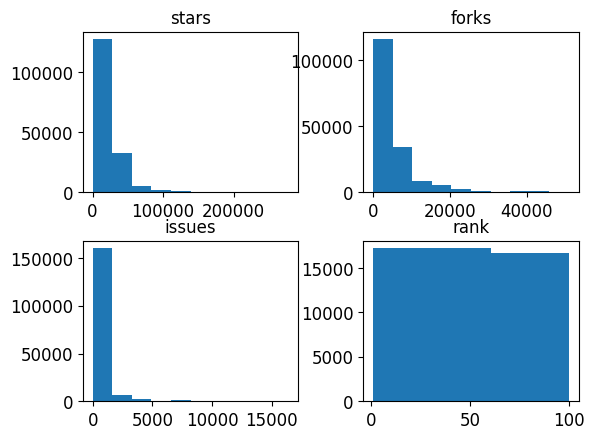

In [18]:
#distribución de las columnas númericas
numerical_col = list(df_cardinalidad["Tipo de dato"][df_cardinalidad["Tipo de dato"] == "numerical"].index)
df[numerical_col].hist(grid=False)

array([[<Axes: title={'center': 'last_commit'}>,
        <Axes: title={'center': 'date'}>]], dtype=object)

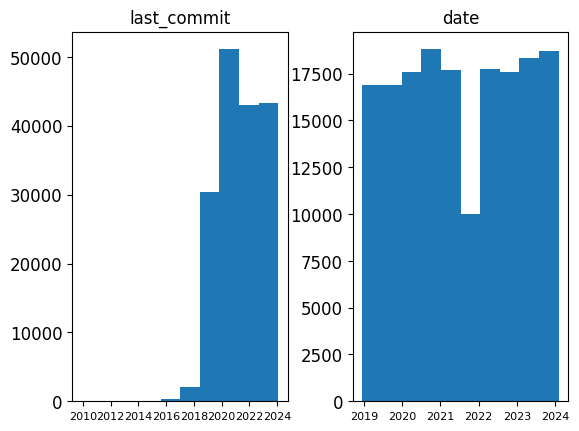

In [19]:
# distribución de las columnas datetime
df[["last_commit", "date"]].hist(grid=False, xlabelsize=(8))

([], [])

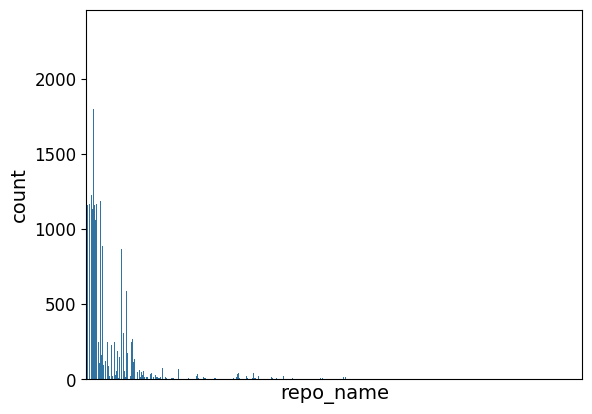

In [20]:
# distribución repo_name
sns.countplot(df, x = "repo_name")
plt.xticks([])

([], [])

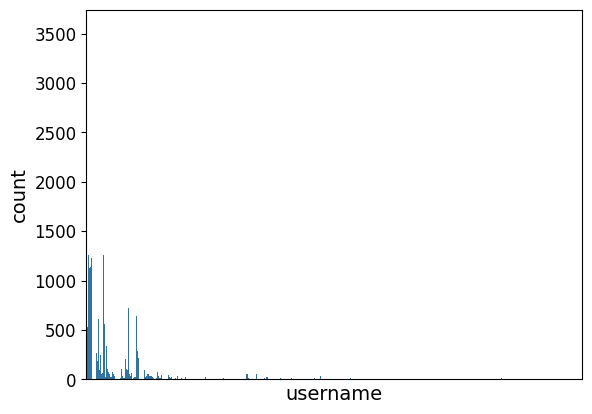

In [21]:
# distribución username
sns.countplot(df, x = "username")
plt.xticks([])

([], [])

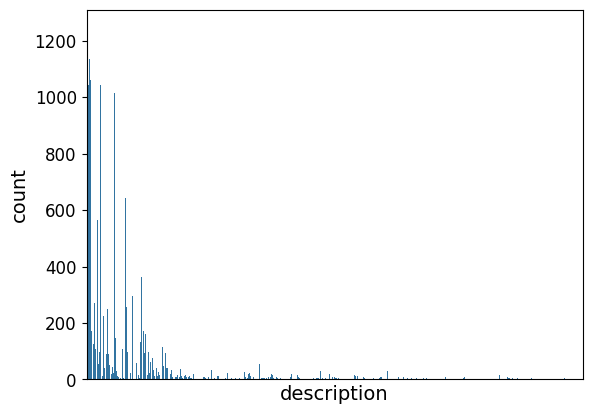

In [22]:
# distribución descripción
sns.countplot(df, x = "description")
plt.xticks([])

Conclusiones del análisis univariante:
- Ninguna variable se ajusta a la normal, la distribución de todas ellas difiere bastante de una campana gaussiana, por lo tanto no procedimos a realizar comprobaciones estadísticas.
- La mayoría de variables tienden a tener una cola hacia la izquierda, lo que indica que hay muchos valores que se repiten poco y probablemente algún outlier o valor atípico muy por encima de la media/moda/mediana.
- La única variable distribuida homogeneamente es la variable *rank*. Pero aún así se observa que hay más valor en el ranking por debajo de 75.
- La variable *last commit* es la única con una cola hacia la derecha, puede deberse a que al ser una variable temporal según se ha ido actualizando el dataset ha ido recogiendo mas información sobre los commits hechos.
- Nuestra variable target, *forks*, presenta una cola a la izquierda con un pequeño repunte entorno a los 40000.

### Análisis bivariante

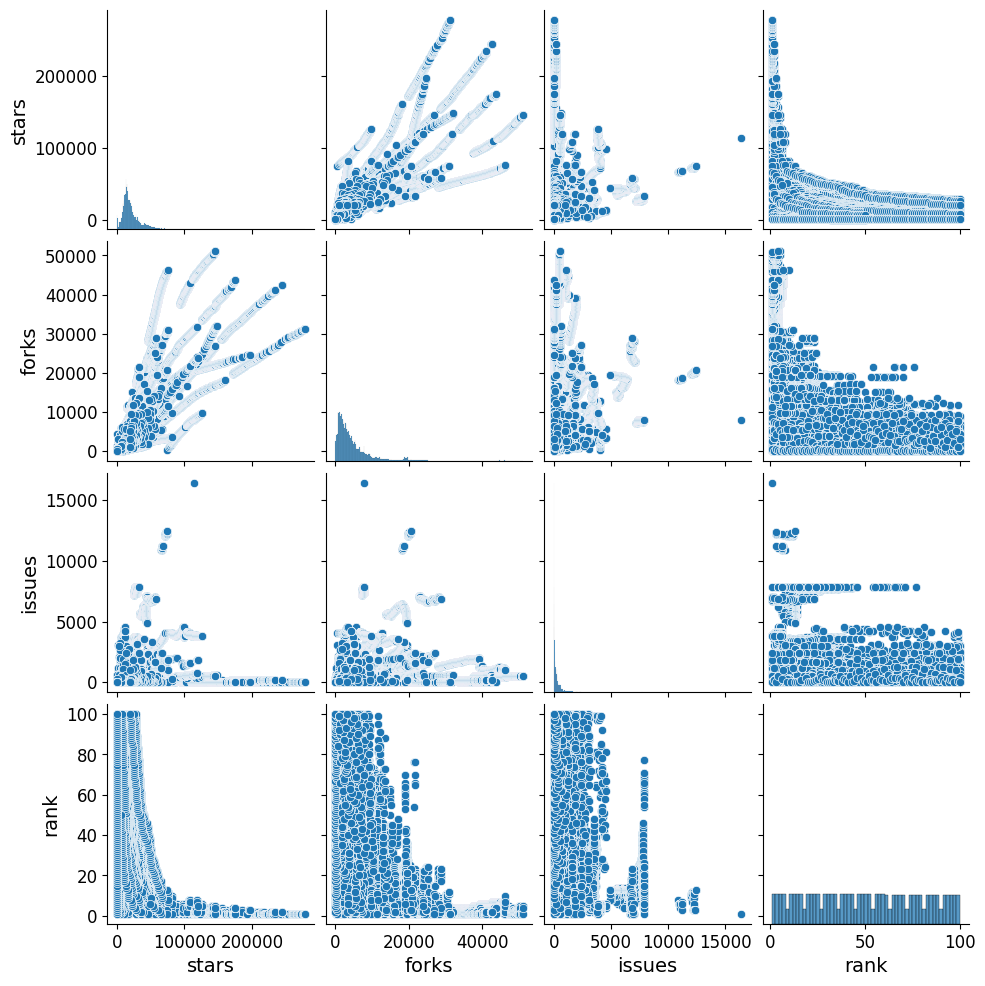

In [23]:
sns.pairplot(df[numerical_col])

<Axes: >

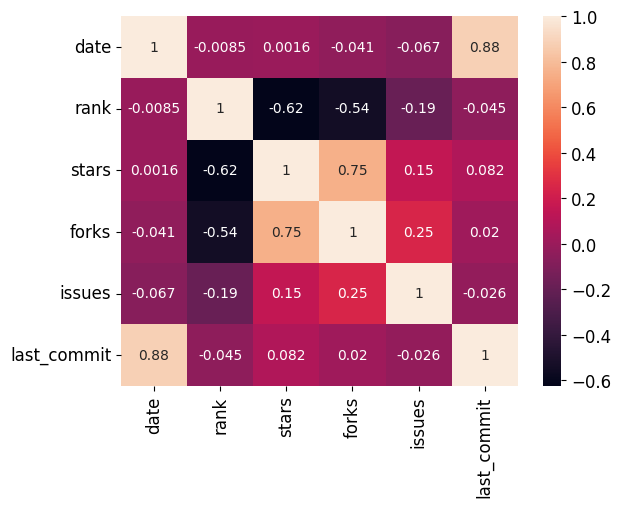

In [24]:
sns.heatmap(df[['date', 'rank', 'stars', 'forks', 'issues',
       'last_commit']].corr(), annot=True)

El análisis bivariante so se va a relizar con las columnas que presentan una gran correlación con la target mientras que el resto se añadirán al análisis multivariante.

- Destacamos la correlación de *forks* con *stars* y con *top*/*rank*.
- También cabe destacar la correlación entre sí de las variables previamente mentadas por su correlación con la target.
- Otra correlación que llama la atención es entre las variables *date* y *last_commit*. Es posible colinealidad.

Además, vamos a crear dos columnas nuevas momentáneamente para facilitar el proceso de graficado. Una que agrupará las filas de 20 en 20 según ranking y otra que agrupará las filas por el año de entrada. 

In [25]:
# agrupación rank -> top
df_1 = df.copy()

df_1["top"] = range(len(df_1))

#top20
df_1["top"].loc[list(df_1[df_1["rank"] <= 20].index)] = 20

#top40
top_20_mas = list(df_1[df_1["rank"] > 20].index)
top_40_menos = list(df_1[df_1["rank"] < 41].index)
top_20_40 = [x for x in top_20_mas if x in top_40_menos]
df_1["top"].loc[top_20_40] = 40

#top60
top_40_mas = list(df_1[df_1["rank"] > 40].index)
top_60_menos = list(df_1[df_1["rank"] < 61].index)
top_40_60 = [x for x in top_40_mas if x in top_60_menos]
df_1["top"].loc[top_40_60] = 60

#top80
top_60_mas = list(df_1[df_1["rank"] > 60].index)
top_80_menos = list(df_1[df_1["rank"] < 81].index)
top_60_80 = [x for x in top_60_mas if x in top_80_menos]
df_1["top"].loc[top_60_80] = 80


#top100
top_100 = list(df_1[df_1["rank"] > 80].index)
df_1["top"].loc[top_100] = 100

df_1["top"].value_counts()

top
20     34440
40     34440
60     34440
80     33480
100    33480
Name: count, dtype: int64

In [26]:
#agrupación años date
df_1["year"] = df_1["date"].dt.year
df_1["year"].value_counts()

year
2023    36120
2020    35500
2022    34360
2019    32900
2021    26800
2024     3300
2018     1300
Name: count, dtype: int64

In [27]:
## agrupando por años last commit
df_1["lc_year"] = df_1["last_commit"].dt.year
df_1["lc_year"].value_counts()

lc_year
2020    36193
2022    35929
2019    33705
2023    29673
2021    28106
2018     3173
2024     1555
2017     1449
2016      301
2015      108
2014       42
2013       30
2012       14
2011        1
2009        1
Name: count, dtype: int64

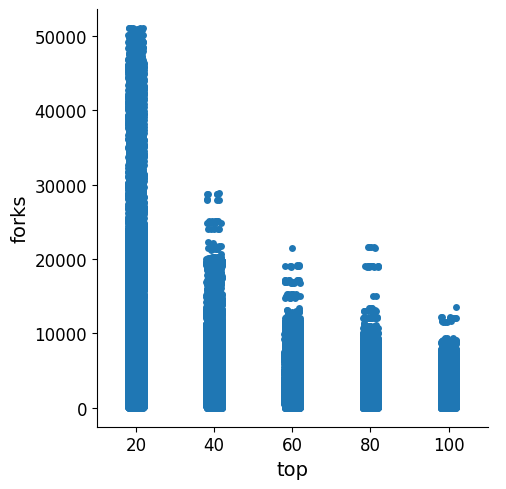

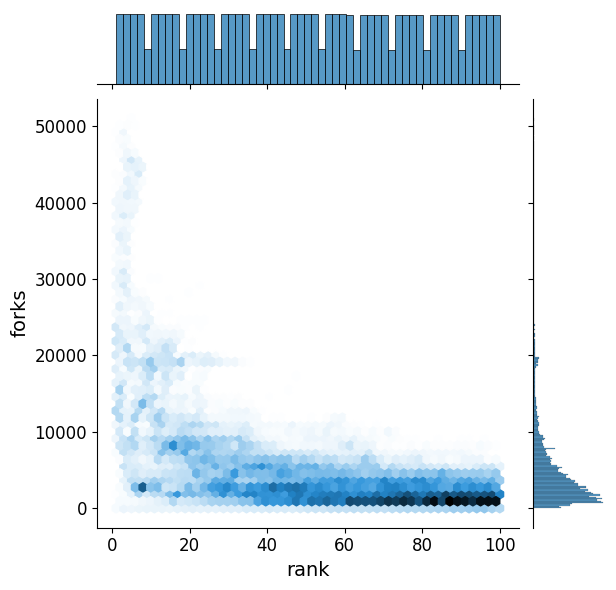

In [28]:
# forks y top/rank
sns.catplot(df_1, y= "forks", x ="top")
sns.jointplot(df_1, y= "forks", x ="rank", kind="hex")

<Axes: xlabel='stars', ylabel='forks'>

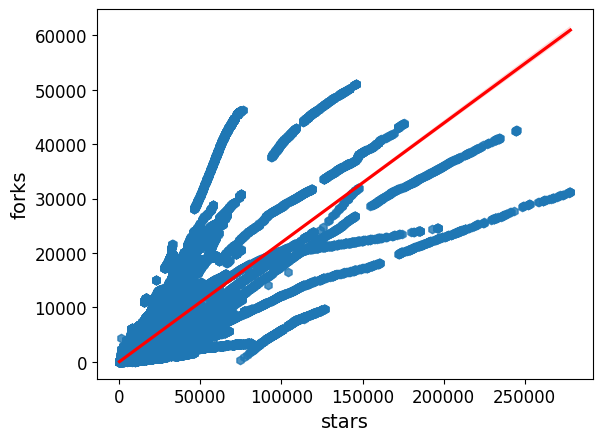

In [29]:
#stars y forks

sns.regplot(df_1, x="stars", y="forks", line_kws=dict(color="r"), marker="h")

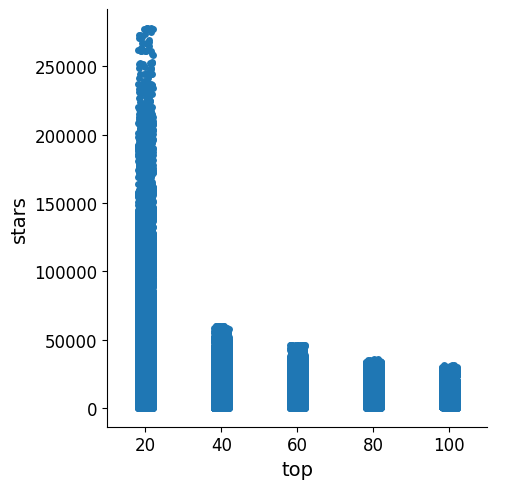

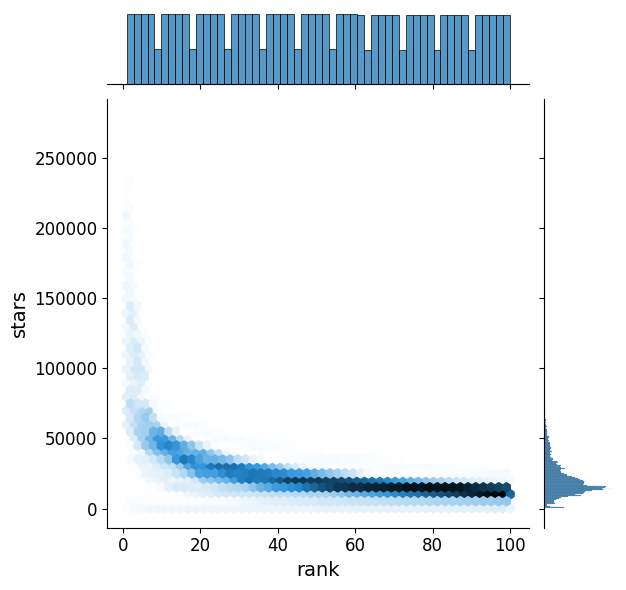

In [30]:
#stars y top/rank

sns.catplot(df_1, y= "stars", x ="top")
sns.jointplot(df_1, y= "stars", x ="rank", kind="hex")

### Análisis Multivariante

<Axes: xlabel='stars', ylabel='forks'>

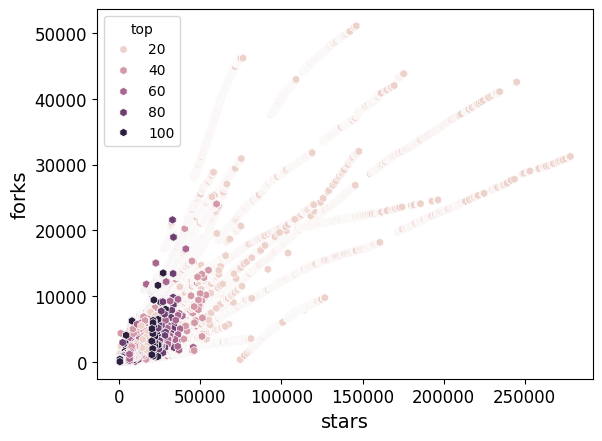

In [31]:
#stars-forks-top

sns.scatterplot(df_1, x="stars", y="forks", marker="h", hue="top")

<Axes: xlabel='year', ylabel='forks'>

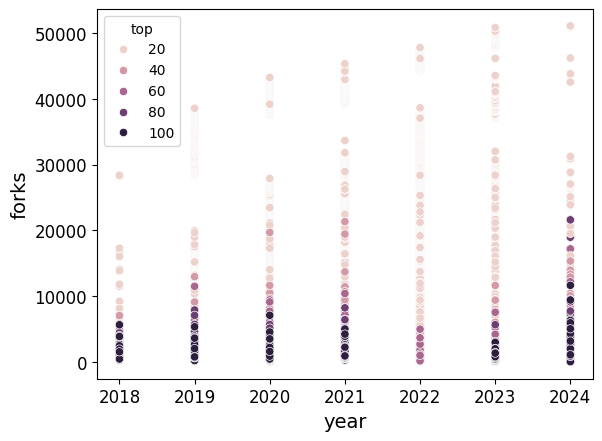

In [32]:
#stars - forks - top
sns.scatterplot(df_1, x="year", y="forks", hue="top")

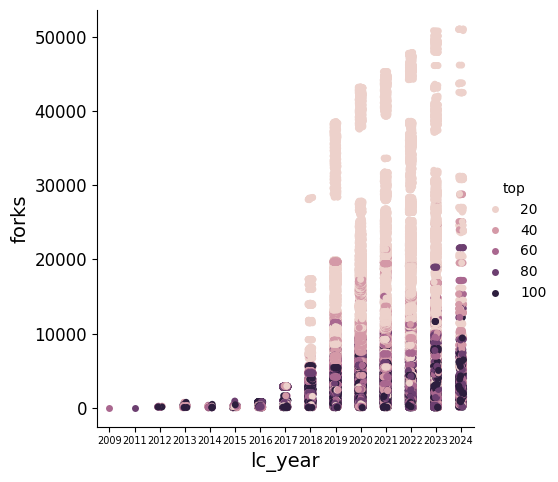

In [33]:
# last_commit, forks, top
sns.catplot(df_1, x="lc_year", y="forks", hue="top")
plt.xticks(size = 7);

Conclusiones del análisis multivariante:
- Cuantas más alto en el ranking y más estrellas tenga un repositorio, más forks se hacen del mismo.
- Pese a que no haya una fuerte correlación, se puede observar cierta tendencia en la cual tanto en la fecha de adición de la entrada al dataset, como el último commit a dicho repositorio influyen en el ranking y por lo tanto en la cantidad de forks realizados.

### Conclusiones generales tras la primera exploración y el EDA

El dataset está bastante limpio y excepto las columnas categóricas, el resto no necesitan demasiado preprocesamiento.

Las variables numéricas a priori mas importantes, con mas correlación con nuestra variable target (*forks*), son *stars* y *rank*. Tiene sentido pues cuanto mejor valorado esté, y más popular sea el repositorio, más forks debería tener.

Por último, pese a la poca correlación que existe entre las variables *last_commit* y *date* con el target, se observa un patrón en ambas variables que indica que cuanto mas cerca del presente este la fecha de subida de la entrada y el último commit, tiende a tener mas forks. Además se puede intuir cierta colinealidad entre las dos variables.

Sobre las variables categóricas, una vez sean tratadas podremos analizarlas.

## 2. Limpieza

### Valores nulos

Como vimos en la exploración incial, el único feature con valores nulos es *description*. Al ser menos de un 1% de los datos y además una variable imposible de imputar, procedemos a eliminar estos valores nulos.

In [34]:
df.dropna(axis=0, inplace=True)

In [35]:
df.shape

(168687, 9)

### Valores Atípicos y outliers

Tras lo visto en el EDA, no existen valores atípicos (imposibles o incoherentes). En cuanto a los outliers, se siente que estos valores aportan mas información útil que ruido, por lo tanto se van a mantener. 

## 3. Feature Engineering

### days since last commit

En este apartado, vamos a crear un nuevo feature *days since last commit (days_since_lc)*. Ya que en el EDA observamos que pese a la poca correlación entre la variable *last_commit* y la target, se observaba cierta tendencia ascendente entre la cantida de forks y la proximidad con el presente del último commit. Con este nuevo feature, pretedemos mantener esa información mientras se evita la posible colinealidad que existe entre las variables *last_commmit* y *date*.

In [36]:
# Ajustando el formato de last commit a date 
lc_y_m_d = [x[0] for x in df["last_commit"].astype(str).str.split(" ")]
df["last_commit"] = lc_y_m_d
df["last_commit"] = pd.to_datetime(df["last_commit"])

# Creando el feature nuevo
df["days_since_lc"] = (df["date"] - df["last_commit"]) / timedelta(days=1)
df.head() 

,date,rank,repo_name,stars,forks,username,issues,last_commit,description,days_since_lc
0,2018-12-18,1,awesome-python,58777,11448,vinta,439,2018-12-13,"A curated list of awesome Python frameworks, l...",5.0
1,2018-12-18,2,system-design-primer,53575,7570,donnemartin,68,2018-12-18,Learn how to design large-scale systems. Prep ...,0.0
2,2018-12-18,3,models,46039,28053,tensorflow,1324,2018-12-18,Models and examples built with TensorFlow,0.0
3,2018-12-18,4,public-apis,45373,4707,toddmotto,5,2018-12-18,A collective list of free APIs for use in soft...,0.0
4,2018-12-18,5,youtube-dl,44956,7820,rg3,2566,2018-12-18,Command-line program to download videos from Y...,0.0


Ahora procederemos a realizar un pequeño análisis exploratorio de esta columna nueva.

<Axes: >

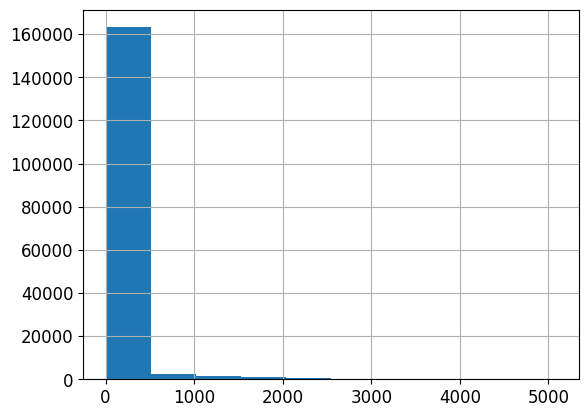

In [37]:
df["days_since_lc"].hist()

<Axes: xlabel='days_since_lc', ylabel='forks'>

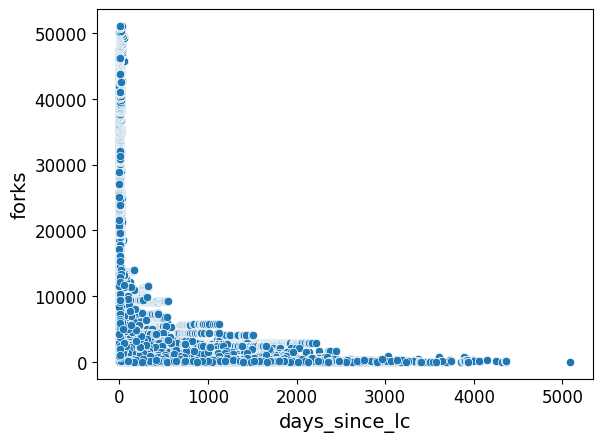

In [38]:
sns.scatterplot(df, x ="days_since_lc", y="forks")

<Axes: >

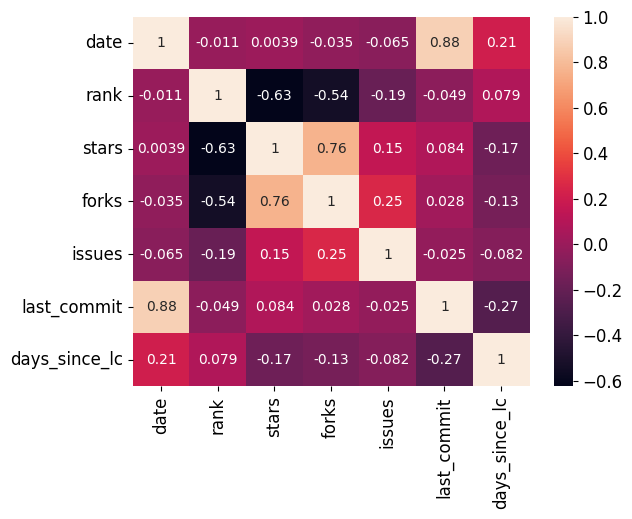

In [39]:
sns.heatmap(df.select_dtypes(exclude='O').corr(), annot=True)

Se puede observar en las gráficas que *days_since_lc* tiene un comportamiento y similar a *last_commit* y ademas hemos eliminado la posible colinealidad con la variable *date*. Por lo tanto vamos a eliminar el feature *last_commit*. 

In [40]:
df.drop(columns="last_commit", inplace=True)

### repos_by_user

La columna *username* es una variable categórica, con información sobre el autor del repositorio. Como vimos en la exploración inicial, no coincide el número de users con el la cantidad de repositorios únicos, por lo tanto tiene que haber autores con mas de un repostorio. El trabajo de feature engineering que vamos a hacer con esta variable es crear una columna la cual nos indique si es un repostorio de un autor "famoso".

In [41]:
# Comprobando que haya usuarios con más de un repositorio
df.groupby("username")["repo_name"].value_counts()

username   repo_name                   
0k         shyaml                             1
0rpc       zerorpc-python                     1
0voice     interview_internal_reference     988
0x5e       wechat-deleted-friends             2
0xAX       linux-insides                   1134
                                           ... 
zulip      zulip                            615
zyantific  IDASkins                           1
zygmuntz   hyperband                          1
           phraug                             1
zzw922cn   Automatic_Speech_Recognition       1
Name: count, Length: 4265, dtype: int64

In [42]:
#usuarios con más de un repo
popular_users = list(df["username"].value_counts()[df["username"].value_counts() > 1].index)

#usuarios por repositorio
n_repos = [df[df["username"] == x]["repo_name"].nunique() for x in popular_users]

# Creando la columna repos_by_user
df = pd.merge(df, pd.DataFrame({'username':popular_users, 'repos_by_user':n_repos}), 'outer', on='username')

# rellenando lo NaNs que quedará, que son para los usuarios con solo un repositorio
df["repos_by_user"].fillna(1, inplace=True)

<Axes: >

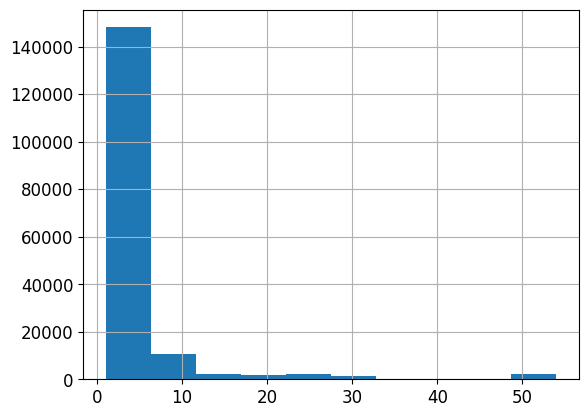

In [43]:
df["repos_by_user"].hist()

<Axes: xlabel='repos_by_user', ylabel='forks'>

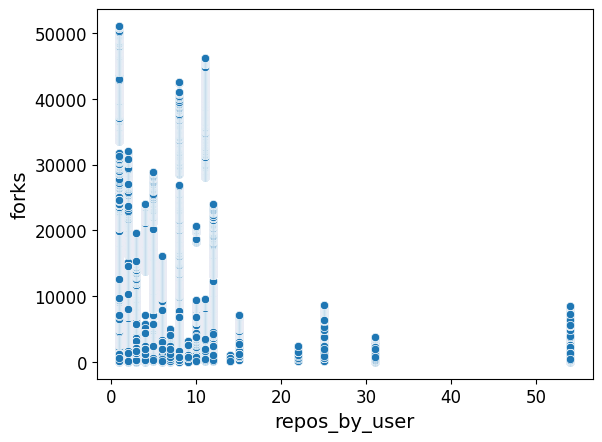

In [44]:
sns.scatterplot(df, x ="repos_by_user", y="forks")

Tras haber creado la columna *repos_by_user* y haber hecho un pequeño análisis exploratorio de la misma, se ve que existe cierta relación inversa entre el número de forks y los repositorios en el top del autor. Aún así, sigue quedando la duda de si el propio nombre del autor influye.

## 4. Tranformaciones y escalado

### NLP

Para poder extraer mas información de la descripción, vamos a realizar la un análisis de sentimientos de la misma utilizando la libreria NLTK. Además tambiém se realizará la vectorización de los textos para posteriormente agruparlos por temas tras una clusterización

In [45]:
# Instanciando el análisis de sentimiento
sia = SentimentIntensityAnalyzer()

# Creando las columnas de análisis de sentimiento
res = {}

for i, x in df.iterrows():
    des = x["description"]
    repo_name = x["repo_name"]
    res[repo_name] = sia.polarity_scores(des)

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index":"repo_name"})
vaders = vaders.merge(df, how="left")

vaders.head()

,repo_name,neg,neu,pos,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,shyaml,0.0,1.0,0.0,0.0,2023-08-09,50,750,57,0k,13,YAML for command line,115.0,1.0
1,zerorpc-python,0.0,1.0,0.0,0.0,2023-11-20,54,3115,416,0rpc,46,zerorpc for python,61.0,1.0
2,interview_internal_reference,0.0,1.0,0.0,0.0,2019-07-23,92,10536,2730,0voice,7,2019年最新总结，阿里，腾讯，百度，美团，头条等技术面试题目，以及答案，专家出题人分析汇总。,0.0,1.0
3,interview_internal_reference,0.0,1.0,0.0,0.0,2019-07-25,62,12382,3284,0voice,6,2019年最新总结，阿里，腾讯，百度，美团，头条等技术面试题目，以及答案，专家出题人分析汇总。,2.0,1.0
4,interview_internal_reference,0.0,1.0,0.0,0.0,2019-07-27,71,13024,3470,0voice,7,2019年最新总结，阿里，腾讯，百度，美团，头条等技术面试题目，以及答案，专家出题人分析汇总。,1.0,1.0


Ahora vamos a realizar un pequeño análisis exploratorio de las columnas que hemos añadido.

In [46]:
df = vaders.copy()

<Axes: xlabel='compound', ylabel='Count'>

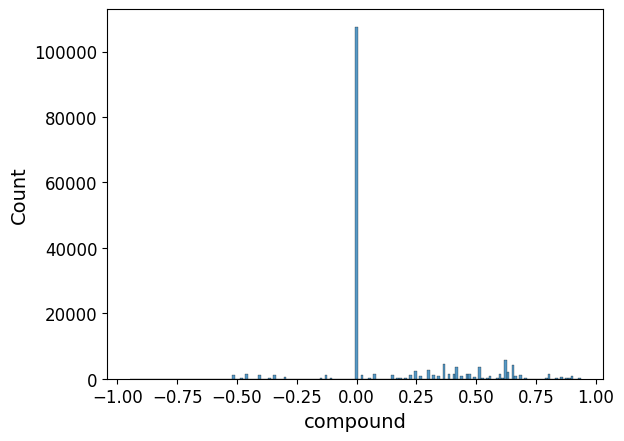

In [47]:
sns.histplot(df, x = "compound")

<Axes: xlabel='neu', ylabel='Count'>

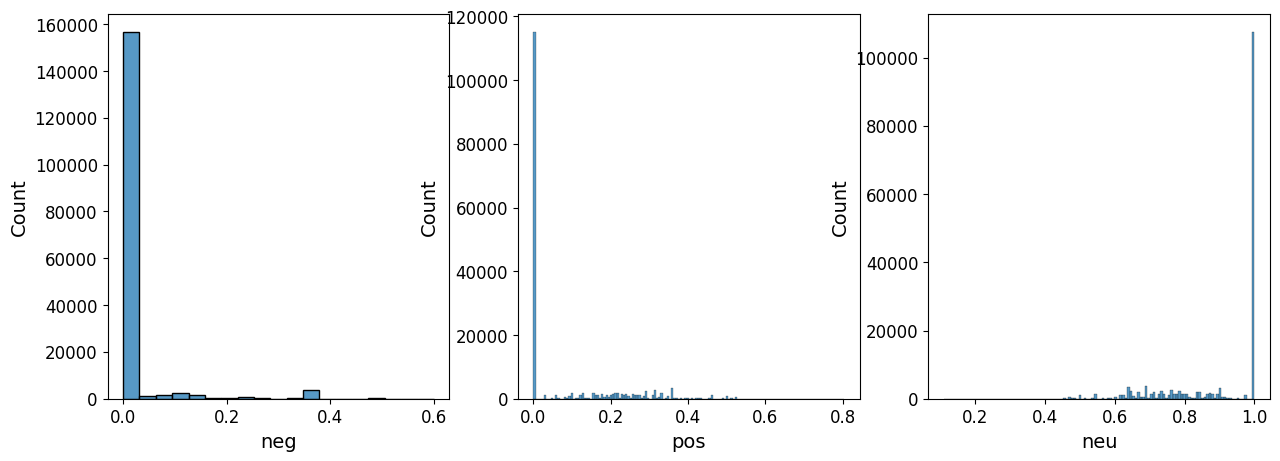

In [48]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.histplot(df, x = "neg", ax=axs[0])
sns.histplot(df, x = "pos", ax=axs[1])
sns.histplot(df, x = "neu", ax=axs[2])

<Axes: >

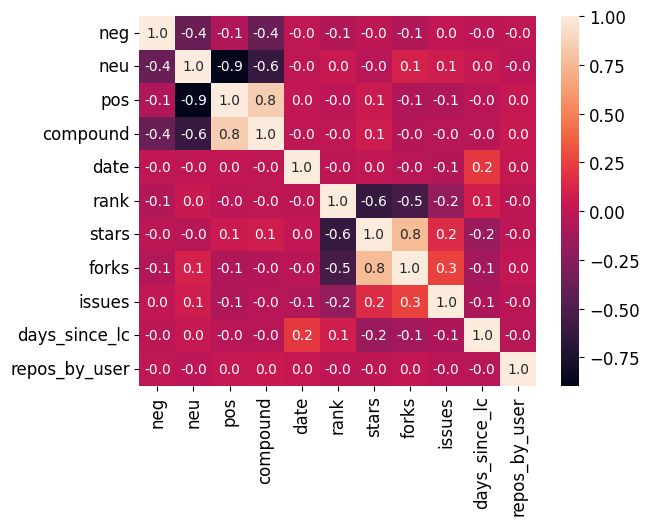

In [49]:
sns.heatmap(df.select_dtypes(exclude='O').corr(), annot=True, fmt=".1f")

Observamos que las columnas de sentimiento tienen mucha correlación entre ellas, por ello nos vamos a quedar solo con *compound* puesto que es una aglomeración de las 3. 

In [50]:
df.drop(columns=['neg', 'neu', 'pos'], inplace=True)

<Axes: xlabel='compound', ylabel='forks'>

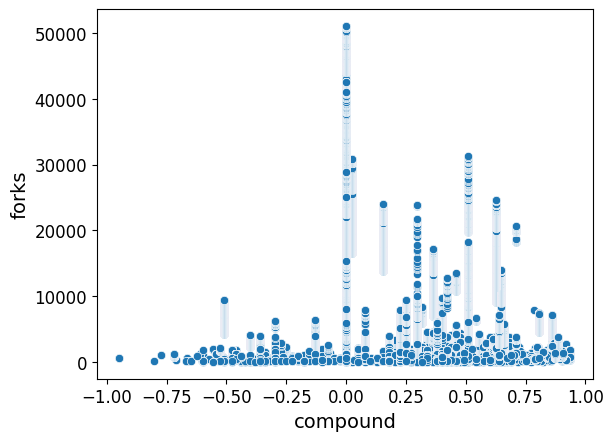

In [51]:
sns.scatterplot(df, x ="compound", y="forks")

Se pueder ver una tendencia en la relación entre el sentimiento de la descripción y el número de forks del repositorio, que el sentimiento sea neutro suele favorecer a la cantidad de forks, y en cuanto se polariza se ve mucho más resentido si el sentimiento es negativo.

Eliminamos los signos de puntuación y emojis del los textos.

In [52]:
signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

def signs_description(des):
    return signos.sub('', des.lower())

df['description'] = df['description'].apply(signs_description)
df['description'].head()

0                          yaml for command line
1                             zerorpc for python
2    年最新总结，阿里，腾讯，百度，美团，头条等技术面试题目，以及答案，专家出题人分析汇总。
3    年最新总结，阿里，腾讯，百度，美团，头条等技术面试题目，以及答案，专家出题人分析汇总。
4    年最新总结，阿里，腾讯，百度，美团，头条等技术面试题目，以及答案，专家出题人分析汇总。
Name: description, dtype: object

In [53]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642" 
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text.lower())


df['description'] = df['description'].apply(remove_emojis)
df['description'].head()

0    yaml for command line
1       zerorpc for python
2                         
3                         
4                         
Name: description, dtype: object

Ahora procedemos a elimnar la stopwords

In [54]:
stopwords_words = stopwords.words('english')

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in stopwords_words])

df['description'] = df['description'].apply(remove_stopwords)
df.head()

,repo_name,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,shyaml,0.0,2023-08-09,50,750,57,0k,13,yaml command line,115.0,1.0
1,zerorpc-python,0.0,2023-11-20,54,3115,416,0rpc,46,zerorpc python,61.0,1.0
2,interview_internal_reference,0.0,2019-07-23,92,10536,2730,0voice,7,,0.0,1.0
3,interview_internal_reference,0.0,2019-07-25,62,12382,3284,0voice,6,,2.0,1.0
4,interview_internal_reference,0.0,2019-07-27,71,13024,3470,0voice,7,,1.0,1.0


El siguiente paso en nuestro proceso es lemmatizar y vectorizar los textos.

In [55]:
def word_lemmatizer(x):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in x.split()])

df['description'] = df['description'].apply(word_lemmatizer)
df['description'].head()

0    yaml command line
1       zerorpc python
2                     
3                     
4                     
Name: description, dtype: object

In [56]:
vectorizer_c = CountVectorizer()
vectorizer_c.fit(df['description'])

X_baseline_c = vectorizer_c.transform(df['description'])

Con las descripciones ya vectorizadas vamos a realizar una clusterización de las mismas para poder agruparlas y encontrar patrones que nos ayuden a mejorar el modelo.

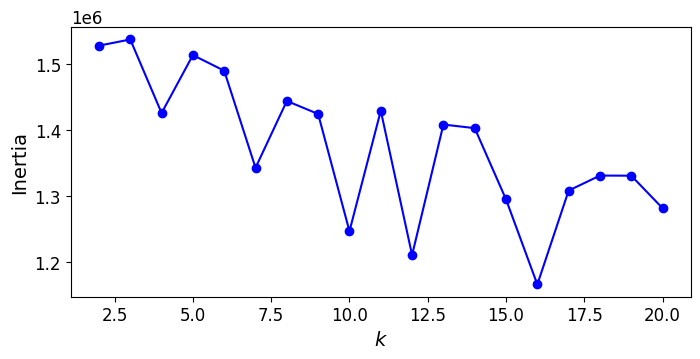

In [156]:
# Buscando el K óptimo
kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42).fit(X_baseline_c)
                for k in range(2, 21)]
inertias = [model.inertia_ for model in kmeans_per_k]

# Gráfica de inercia
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 21), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)


plt.show()

In [38]:
silhouette_scores = [silhouette_score(X_baseline_c, model.labels_)
                     for model in kmeans_per_k[2:12]]

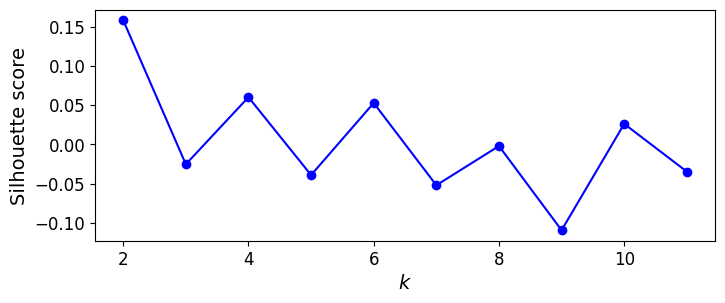

In [39]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 12), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

El mejor valor para el parámetro k es 8. Creamos el modelo para poder clusterizar

In [57]:
kmeans = MiniBatchKMeans(8, random_state=42).fit(X_baseline_c)

# añadiendo la columna cluster al dataframe
df['cluster'] = kmeans.labels_
df.head()

,repo_name,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user,cluster
0,shyaml,0.0,2023-08-09,50,750,57,0k,13,yaml command line,115.0,1.0,3
1,zerorpc-python,0.0,2023-11-20,54,3115,416,0rpc,46,zerorpc python,61.0,1.0,4
2,interview_internal_reference,0.0,2019-07-23,92,10536,2730,0voice,7,,0.0,1.0,3
3,interview_internal_reference,0.0,2019-07-25,62,12382,3284,0voice,6,,2.0,1.0,3
4,interview_internal_reference,0.0,2019-07-27,71,13024,3470,0voice,7,,1.0,1.0,3


Es posible explorar los clusters, para ello vamos a crear un df para cada cluster y examinar cuales son las palabras que más se repiten en cada uno de ellos, de esta manera poder entender porque temáticas o en que se ha basado el modelo kmeans para las agrupaciones.

In [40]:
# Creando un diccionario con los clusters
cluster_texts_dict = {i: [] for i in range(8)}
for index, row in df.iterrows():
    cluster_texts_dict[row['cluster']].append(row['description'])

cluster_data = [{'cluster_id': cluster_id, 'text': text} for cluster_id, texts in cluster_texts_dict.items() for text in texts]

In [41]:
# Pasando el diccionario a dataframe
cluster_df = pd.DataFrame(cluster_data)

# Se elminan los duplicados puesto que hay descripciones repetidas de los repositiorios que aparecen más de una vez
cluster_df.drop_duplicates(inplace=True)

#Un dataframe por cluster
cluster_0 = cluster_df[cluster_df["cluster_id"] == 0]
cluster_1 = cluster_df[cluster_df["cluster_id"] == 1]
cluster_2 = cluster_df[cluster_df["cluster_id"] == 2]
cluster_3 = cluster_df[cluster_df["cluster_id"] == 3]
cluster_4 = cluster_df[cluster_df["cluster_id"] == 4]
cluster_5 = cluster_df[cluster_df["cluster_id"] == 5]
cluster_6 = cluster_df[cluster_df["cluster_id"] == 6]
cluster_7 = cluster_df[cluster_df["cluster_id"] == 7]

In [42]:
# Creando una función pars tokezinar las palabras de las descripciones y poder ver las mas frecuentes
def tokenize_text(text):
    return word_tokenize(text)

In [43]:
# Análisis cluster 0

cluster_0['tokenized_column'] = cluster_0['text'].apply(tokenize_text)

cluster_0_words = []

for x in cluster_0["tokenized_column"]:
    cluster_0_words.append(x)

concatenated_cluster0 = [item for sublist in cluster_0_words for item in sublist]

word_freq = Counter(concatenated_cluster0)

word_freq.most_common(10)

[('data', 77),
 ('&', 8),
 ('python', 8),
 ('database', 6),
 ('science', 5),
 ('analysis', 5),
 ('image', 4),
 ('text', 4),
 ('ai', 4),
 ('store', 4)]

Las palabras más frecuentes del cluster nos indican que el modelo kmeans ha creado este cluster agrupando descripciones que tratan sobre análisis de bases de datos, textos e imagenes.

In [44]:
# Análisis cluster 1

cluster_1['tokenized_column'] = cluster_1['text'].apply(tokenize_text)

cluster_1_words = []

for x in cluster_1["tokenized_column"]:
    cluster_1_words.append(x)

concatenated_cluster1 = [item for sublist in cluster_1_words for item in sublist]

word_freq = Counter(concatenated_cluster1)

word_freq.most_common(10)

[('learning', 63),
 ('pytorch', 58),
 ('deep', 36),
 ('model', 28),
 ('state-of-the-art', 27),
 ('implementation', 19),
 ('language', 19),
 ('processing', 18),
 ('nlp', 18),
 ('natural', 17)]

Las palabras más frecuentes del cluster nos indican que el modelo kmeans ha creado este cluster agrupando descripciones que tratan sobre modelos de deep learning, especialmente de NLP. 

In [46]:
# Análisis cluster 2
cluster_2['tokenized_column'] = cluster_2['text'].apply(tokenize_text)

cluster_2_words = []

for x in cluster_2["tokenized_column"]:
    cluster_2_words.append(x)

concatenated_cluster2 = [item for sublist in cluster_2_words for item in sublist]

word_freq = Counter(concatenated_cluster2)

word_freq.most_common(10)

[('api', 128),
 ('python', 41),
 ('chatgpt', 20),
 ('using', 14),
 ("'s", 14),
 ('client', 14),
 ('http', 12),
 ('support', 11),
 ('wrapper', 11),
 ('json', 10)]

Las palabras más frecuentes del cluster nos indican que el modelo kmeans ha creado este cluster agrupando descripciones que tratan sobre aplicaciones y el soporte de estás en línea. 

In [47]:
# Análisis cluster 3

cluster_3['tokenized_column'] = cluster_3['text'].apply(tokenize_text)

cluster_3_words = []

for x in cluster_3["tokenized_column"]:
    cluster_3_words.append(x)

concatenated_cluster3 = [item for sublist in cluster_3_words for item in sublist]

word_freq = Counter(concatenated_cluster3)

word_freq.most_common(10)

[('“', 269),
 ('”', 261),
 ('model', 250),
 ('learning', 218),
 ('implementation', 199),
 ('code', 182),
 ('network', 175),
 ('tool', 172),
 ('tensorflow', 167),
 ('framework', 165)]

Las palabras más frecuentes del cluster nos indican que el modelo kmeans ha creado este cluster agrupando descripciones que tratan sobre modelos de aprendijaze e implementación de redes neuronales.

In [48]:
# Análisis cluster 4

cluster_4['tokenized_column'] = cluster_4['text'].apply(tokenize_text)

cluster_4_words = []

for x in cluster_4["tokenized_column"]:
    cluster_4_words.append(x)

concatenated_cluster4 = [item for sublist in cluster_4_words for item in sublist]

word_freq = Counter(concatenated_cluster4)

word_freq.most_common(10)

[('python', 864),
 ('library', 169),
 ('framework', 87),
 ('web', 58),
 ('-', 50),
 ('data', 49),
 ('learning', 47),
 ('client', 44),
 ('code', 42),
 ('written', 42)]

Las palabras más frecuentes del cluster nos indican que el modelo kmeans ha creado este cluster agrupando descripciones que tratan sobre librerias para el trabajo de desarrollo web y el análisis de datos.

In [49]:
# Análisis cluster 5

cluster_5['tokenized_column'] = cluster_5['text'].apply(tokenize_text)

cluster_5_words = []

for x in cluster_5["tokenized_column"]:
    cluster_5_words.append(x)

concatenated_cluster5 = [item for sublist in cluster_5_words for item in sublist]

word_freq = Counter(concatenated_cluster5)

word_freq.most_common(10)

[('learning', 12),
 ('machine', 8),
 ('deep', 4),
 ('/', 4),
 ('scratch', 3),
 ('bare', 3),
 ('bone', 3),
 ('implementation', 3),
 ('model', 3),
 ('algorithm', 3)]

Las palabras más frecuentes del cluster nos indican que el modelo kmeans ha creado este cluster agrupando descripciones que tratan sobre modelos de machine learning e implementación de algoritmos

In [50]:
cluster_6['tokenized_column'] = cluster_6['text'].apply(tokenize_text)

cluster_6_words = []

for x in cluster_6["tokenized_column"]:
    cluster_6_words.append(x)

concatenated_cluster6 = [item for sublist in cluster_6_words for item in sublist]

word_freq = Counter(concatenated_cluster6)

word_freq.most_common(10)

[('system', 4),
 ('application', 3),
 ('deploy', 3),
 ('ansible', 2),
 ('radically', 2),
 ('simple', 2),
 ('automation', 2),
 ('platform', 2),
 ('make', 2),
 ('easier', 2)]

Las palabras más frecuentes del cluster nos indican que el modelo kmeans ha creado este cluster agrupando descripciones que tratan sobre sistemas para la automatización y la facilitación del despliegur de aplicaciones.

In [51]:
cluster_7['tokenized_column'] = cluster_7['text'].apply(tokenize_text)

cluster_7_words = []

for x in cluster_7["tokenized_column"]:
    cluster_7_words.append(x)

concatenated_cluster7 = [item for sublist in cluster_7_words for item in sublist]

word_freq = Counter(concatenated_cluster7)

word_freq.most_common(10)

[('security', 4),
 ('application', 3),
 ('mobile', 3),
 ('owasp', 2),
 ('cheat', 2),
 ('sheet', 2),
 ('testing', 2),
 ('series', 1),
 ('created', 1),
 ('provide', 1)]

Las palabras más frecuentes del cluster nos indican que el modelo kmeans ha creado este cluster agrupando descripciones que tratan sobre la seguridad y pruebas y trabajo en apliaciones móviles.

<Axes: xlabel='cluster', ylabel='Count'>

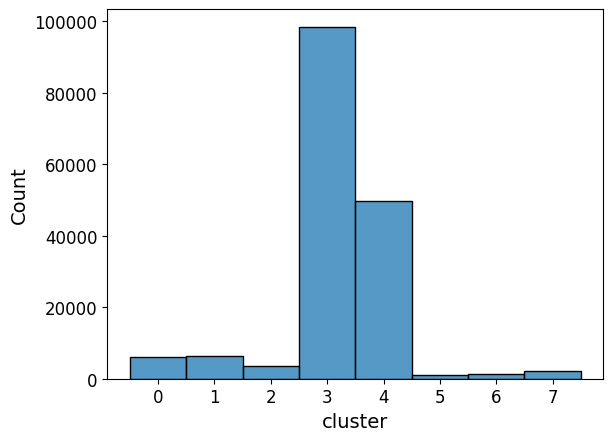

In [53]:
# Distribución de los cluster

sns.histplot(df, x="cluster", discrete=True)

La mayoría de decripciones se encuentran agrupadas en los cluster 3 y 4, lo que nos quiere indicar que principalmente los repositorios estan orientados en redes neuronales y el desarrollo web.

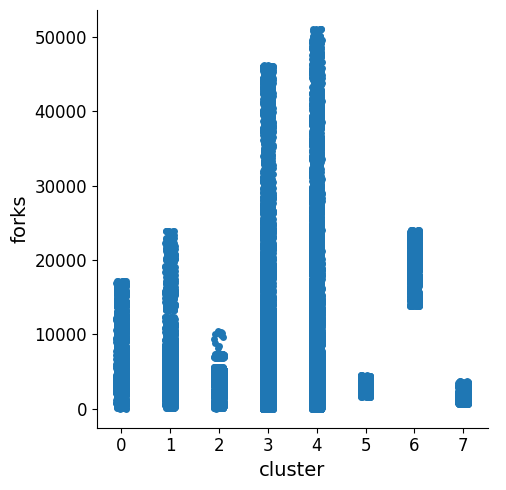

In [52]:
# Cluster vs forks
sns.catplot(data=df, x="cluster", y="forks")

A parte de ser los cluster con mayor número de repostirios, también son los que contiene los repositorios con maas forks. Por lo que nos deja intuir la popularidad de dichos temas.

<Axes: xlabel='cluster', ylabel='compound'>

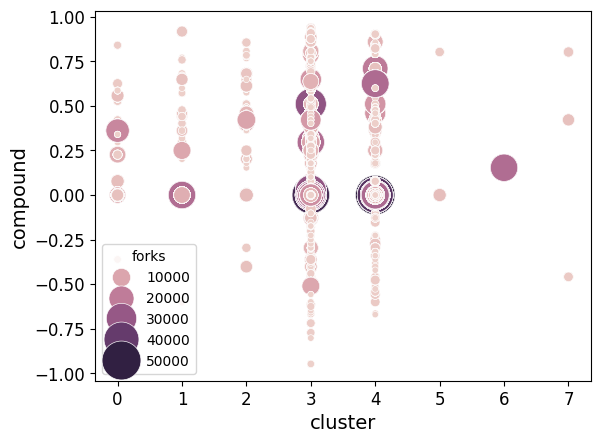

In [54]:
#Relación cluster-sentimiento en función de los forks
sns.scatterplot(data=df, y="compound", x="cluster", hue="forks", size="forks", sizes=(20, 800))

En cuanto al sentimiento, como vimos anteriormente, el sentimiento neutro suele favorecer a la canrtidad de forks.

### Label Encoder

Vamos a tranformar las dos columnas que quedan utilizando el método label encoder, puesto que crear dummies es inviable con la cantidad de únicos que tienen.

In [58]:
# instanciando el label encoder
le = LabelEncoder()

#eliminando la columna descripción pues ya tenemos el cluster que agrupa las descripciones
df = df.drop(columns=["description"])

df["repo_name"] = le.fit_transform(df["repo_name"])
df["username"] = le.fit_transform(df["username"])

df.head()

,repo_name,compound,date,rank,stars,forks,username,issues,days_since_lc,repos_by_user,cluster
0,3536,0.0,2023-08-09,50,750,57,0,13,115.0,1.0,3
1,4136,0.0,2023-11-20,54,3115,416,1,46,61.0,1.0,4
2,2381,0.0,2019-07-23,92,10536,2730,2,7,0.0,1.0,3
3,2381,0.0,2019-07-25,62,12382,3284,2,6,2.0,1.0,3
4,2381,0.0,2019-07-27,71,13024,3470,2,7,1.0,1.0,3


## Escalado

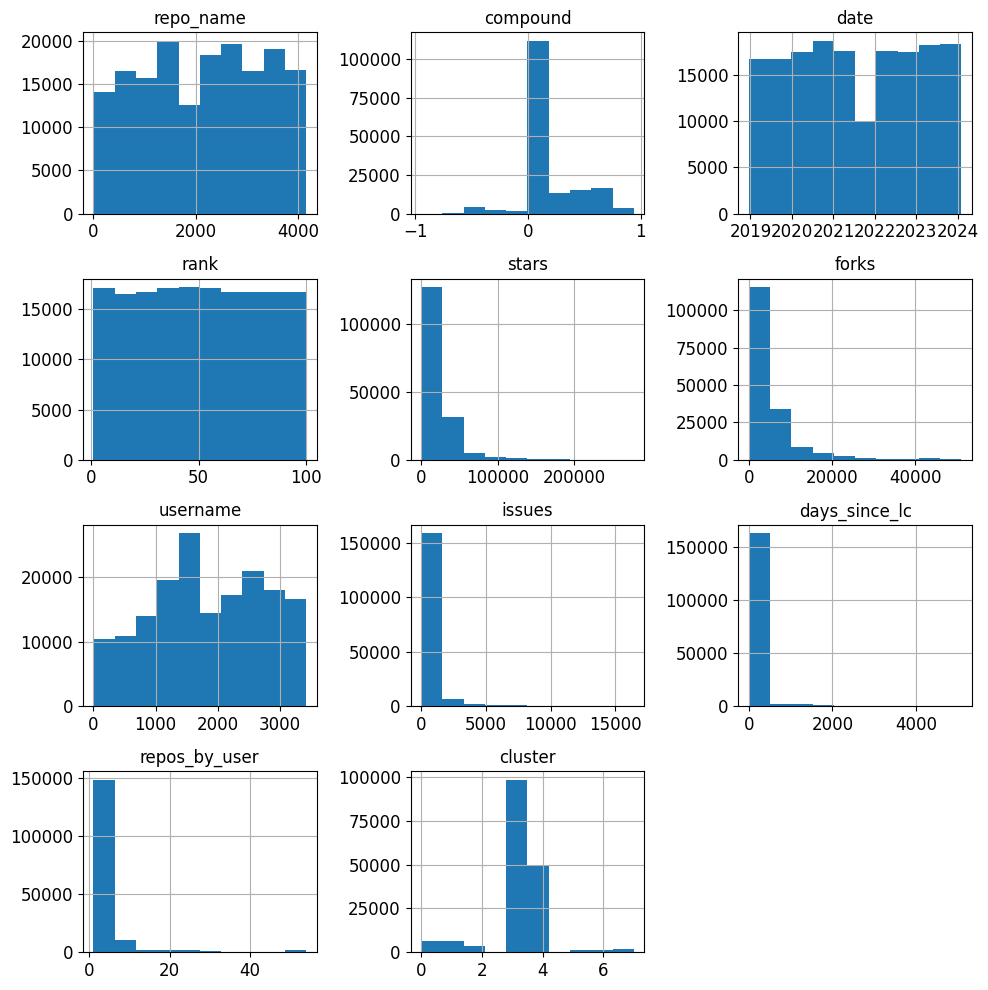

In [59]:
df.hist(figsize=(10,10))
plt.tight_layout()

Debido a las características de los features (no se ajustan a la normal, son variables discretas y hay outliers), el escalado será realizado mediante el método ``RobustScaler``.

In [60]:
# Prerando la columna Date para poder escalarla
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

df.drop(columns="date", inplace=True)

In [61]:
RobEsc = RobustScaler()
esc_features = RobEsc.fit_transform(df[['repo_name', 'rank', 'stars', 'forks', 'username', 'issues',
       'days_since_lc', 'repos_by_user', 'day', 'month', 'year']])

df[['repo_name', 'rank', 'stars', 'forks', 'username', 'issues',
       'days_since_lc', 'repos_by_user', 'day', 'month', 'year']] = esc_features

df.head()

,repo_name,compound,rank,stars,forks,username,issues,days_since_lc,repos_by_user,cluster,day,month,year
0,0.625844,0.0,0.000000,-1.184326,-0.707295,-1.203413,-0.354651,6.222222,0.0,3,-0.466667,0.333333,1.0
1,0.915140,0.0,0.081633,-1.022450,-0.627447,-1.202730,-0.258721,3.222222,0.0,4,0.266667,0.833333,1.0
2,0.068949,0.0,0.857143,-0.514511,-0.112767,-1.202048,-0.372093,-0.166667,0.0,3,0.466667,0.166667,-1.0
3,0.068949,0.0,0.244898,-0.388159,0.010454,-1.202048,-0.375000,-0.055556,0.0,3,0.600000,0.166667,-1.0
4,0.068949,0.0,0.428571,-0.344216,0.051824,-1.202048,-0.372093,-0.111111,0.0,3,0.733333,0.166667,-1.0


## 5. Clusterización

Vamos a utilizar un modelo no supervidado como preprocesamiento para poder ajustar mejor las predicciones. En este caso nos hemos decantado por el ``kmeans-minibatch`` ya que nos facilitará el proceso de computación.

In [62]:
# quitamos la target

df_cluster = df.drop(columns="forks") 

# Buscando el K óptimo
kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42).fit(df_cluster)
                for k in range(2, 21)]
inertias = [model.inertia_ for model in kmeans_per_k]

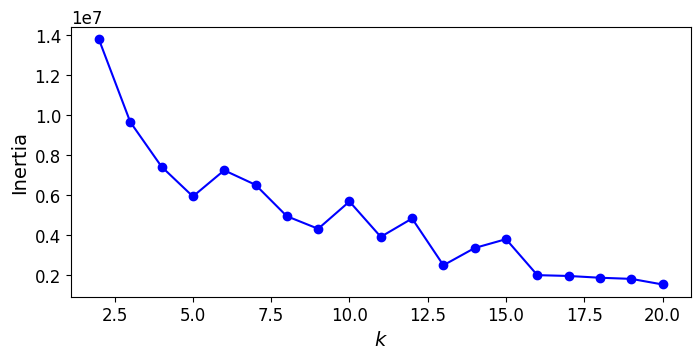

In [63]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 21), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)


plt.show()

El kmeans óptimo es k=3.

In [64]:
# Instanciamos el modelo
kmeans = MiniBatchKMeans(3, random_state=42).fit(df_cluster)

In [65]:
# Añadimos los cluster al df
clusterized = kmeans.predict(df_cluster)
df_cluster["forks"] = df["forks"]
df_cluster["cluster_result"] = clusterized

df_cluster.head()

,repo_name,compound,rank,stars,username,issues,days_since_lc,repos_by_user,cluster,day,month,year,forks,cluster_result
0,0.625844,0.0,0.000000,-1.184326,-1.203413,-0.354651,6.222222,0.0,3,-0.466667,0.333333,1.0,-0.707295,2
1,0.915140,0.0,0.081633,-1.022450,-1.202730,-0.258721,3.222222,0.0,4,0.266667,0.833333,1.0,-0.627447,2
2,0.068949,0.0,0.857143,-0.514511,-1.202048,-0.372093,-0.166667,0.0,3,0.466667,0.166667,-1.0,-0.112767,2
3,0.068949,0.0,0.244898,-0.388159,-1.202048,-0.375000,-0.055556,0.0,3,0.600000,0.166667,-1.0,0.010454,2
4,0.068949,0.0,0.428571,-0.344216,-1.202048,-0.372093,-0.111111,0.0,3,0.733333,0.166667,-1.0,0.051824,2


In [66]:
# Separamos por cluster para hacer un modelo por cada uno
df_cluster_0 = df_cluster[df_cluster["cluster_result"] == 0]
df_cluster_1 = df_cluster[df_cluster["cluster_result"] == 1]
df_cluster_2 = df_cluster[df_cluster["cluster_result"] == 2]

## 6. Modelo Cluster 0

### Separación de los datos

In [67]:
# Separación en train y test
train_0, test_0 = train_test_split(df_cluster_0, test_size=0.2, random_state=42)

# Separación en train y val
X = train_0.drop(columns="forks")
y = train_0["forks"]

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)

### BaseLines

In [68]:
# modelos
modelos = {
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor()
}

# Define las métricas a usar
metricas = "r2"

resultados_dict = {}

for modelo in modelos:

    resultados_dict[modelo] = [cross_val_score(modelos[modelo], X_train, y_train, scoring="r2", cv=3).mean()]

#resultado
pd.DataFrame(resultados_dict).T.rename(columns={0:"Score"})

,Score
LinearRegression,0.854849
ElasticNet,0.060734
Ridge,0.854852
Lasso,0.046129
DecisionTree,0.980826
RandomForest,0.988675
AdaBoost,0.831786
GradientBoost,0.967565
HistGradientBoosting,0.987413


Los modelos con mejor score son el árbol de decisión, random forest y HGB. Vamos a decidir entre los tres mediante un ``Voting``.

In [69]:
# Instanciando el voting
VotingR = VotingRegressor(estimators=
                          [
                              ("dt", DecisionTreeRegressor(random_state=42)),
                              ("hgb", HistGradientBoostingRegressor(random_state=42)),
                              ("rf", RandomForestRegressor(random_state=42))
                          ])
# Entrenando el voting
VotingR.fit(X_train, y_train)

#monstrando resultados
for name, clf in VotingR.named_estimators_.items():
    print(name, "=", clf.score(X_val, y_val))

dt = 0.9890388518516725
hgb = 0.9887895680443769
rf = 0.9919025078579882


Elegimos el árbol de decisión puesto que su score es similar a los otros dos y es el más fácil de explicar.

### Optimización y entrenamiento

In [70]:
# parámetros a evaluar
param_grid = {
    'max_depth': [0, 1, 2, 3, 4, 5],
    'min_samples_leaf': np.arange(1,10),
    'max_features': np.arange(2,12),
    'splitter':["best", "random"], 
    'min_samples_leaf': np.arange(2,5)
    

}

# modelo
decicsion_tree_r = DecisionTreeRegressor(random_state=42)

# gridsearch
grid_search = GridSearchCV(decicsion_tree_r,
                           param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1
                          )

# Entrenamiento
grid_search.fit(X_train, y_train)

# instanciando modelo entrenado en una variable
dtr = grid_search.best_estimator_

# mostrando mejores valores

print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 2, 'splitter': 'best'}


### Métricas y validación

Vamos a realizar una prediccion para ver como se ajusta el modelo a los valores de validación.

In [71]:
pred = dtr.predict(X_val)

print("train r2:", r2_score(y_val, pred))
print('val r2:', r2_score(y_val, pred))
print("MAE:", mean_absolute_error(y_val, pred))
print("MSE:", mean_squared_error(y_val, pred))
print("MAPE:", mean_absolute_percentage_error(y_val, pred))

train r2: 0.936666916450777
val r2: 0.936666916450777
MAE: 0.07201779403946056
MSE: 0.013076435503111038
MAPE: 1.2249143812307386


El modelo se ajusta correctamente a los datos de validación.

### Test

In [72]:
# Separando en x_test e y_test
X_test = test_0.drop(columns="forks")
y_test = test_0["forks"]

In [73]:
# Métricas del test
pred_test = dtr.predict(X_test)
print("r2:", r2_score(y_test, pred_test))
print("MAE:", mean_absolute_error(y_test, pred_test))
print("MSE:", mean_squared_error(y_test, pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_test))

r2: 0.9498794548818074
MAE: 0.0676245318298273
MSE: 0.010487328716012559
MAPE: 0.4443816239838882


In [74]:
# Viendo como se ajusta el modelo
print('train', r2_score(y_train, dtr.predict(X_train)))
print('val', r2_score(y_val, pred))
print('test', r2_score(y_test, pred_test))

train 0.9447010692709054
val 0.936666916450777
test 0.9498794548818074


El modelo no pierde eficacia tras pasarle los datos de test, por lo tanto es un modelo listo para usarse.

## 7. Modelo Cluster 1

### Separación de datos

In [75]:
# Separación en train y test
train_1, test_1 = train_test_split(df_cluster_1, test_size=0.2, random_state=42)

# Separación en train y val
X = train_1.drop(columns="forks")
y = train_1["forks"]

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)

### BaseLines

In [76]:
# modelos
modelos = {
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor()
}

# Define las métricas a usar
metricas = "r2"

resultados_dict = {}

for modelo in modelos:

    resultados_dict[modelo] = [cross_val_score(modelos[modelo], X_train, y_train, scoring="r2", cv=3).mean()]

#resultado
pd.DataFrame(resultados_dict).T.rename(columns={0:"Score"})

,Score
LinearRegression,0.891450
ElasticNet,0.155691
Ridge,0.891471
Lasso,0.144028
DecisionTree,0.984809
RandomForest,0.989279
AdaBoost,0.962109
GradientBoost,0.981844
HistGradientBoosting,0.984025


Los modelos con mejor score son el árbol de decisión, random forest y HGB. Vamos a decidir entre los tres mediante un ``Voting``.

In [77]:
# Instanciando el voting
VotingR = VotingRegressor(estimators=
                          [
                              ("dt", DecisionTreeRegressor(random_state=42)),
                              ("hgb", HistGradientBoostingRegressor(random_state=42)),
                              ("rf", RandomForestRegressor(random_state=42))
                          ])
# Entrenando el voting
VotingR.fit(X_train, y_train)

#monstrando resultados
for name, clf in VotingR.named_estimators_.items():
    print(name, "=", clf.score(X_val, y_val))

dt = 0.9886138232590721
hgb = 0.9870231612905915
rf = 0.990791541831202


Elegimos el árbol de decisión puesto que su score es similar a los otros dos y es el más fácil de explicar.

### Optimización y entrenamiento

In [78]:
# parámetros a evaluar
param_grid = {
    'max_depth': [0, 1, 2, 3, 4, 5],
    'min_samples_leaf': np.arange(1,10),
    'max_features': np.arange(2,12),
    'splitter':["best", "random"], 
    'min_samples_leaf': np.arange(2,5)
    

}

# modelo
decicsion_tree_r = DecisionTreeRegressor(random_state=42)

# gridsearch
grid_search = GridSearchCV(decicsion_tree_r,
                           param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1
                          )

# Entrenamiento
grid_search.fit(X_train, y_train)

# instanciando modelo entrenado en una variable
dtr = grid_search.best_estimator_

# mostrando mejores valores

print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 2, 'splitter': 'best'}


### Métricas y validación

Vamos a realizar una prediccion para ver como se ajusta el modelo a los valores de validación.

In [79]:
pred = dtr.predict(X_val)

print("train r2:", r2_score(y_val, pred))
print('val r2:', r2_score(y_val, pred))
print("MAE:", mean_absolute_error(y_val, pred))
print("MSE:", mean_squared_error(y_val, pred))
print("MAPE:", mean_absolute_percentage_error(y_val, pred))

train r2: 0.9728159320134669
val r2: 0.9728159320134669
MAE: 0.022850823622525815
MSE: 0.0016493258381129554
MAPE: 0.040001338051548214


El modelo se ajusta correctamente a los datos de validación.

### Test

In [80]:
# Separando en x_test e y_test
X_test = test_1.drop(columns="forks")
y_test = test_1["forks"]

In [81]:
# Métricas del test
pred_test = dtr.predict(X_test)
print("r2:", r2_score(y_test, pred_test))
print("MAE:", mean_absolute_error(y_test, pred_test))
print("MSE:", mean_squared_error(y_test, pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_test))

r2: 0.962893340811185
MAE: 0.02335597632366662
MSE: 0.002105453096365837
MAPE: 0.0443229248992092


In [82]:
# Viendo como se ajusta el modelo
print('train', r2_score(y_train, dtr.predict(X_train)))
print('val', r2_score(y_val, pred))
print('test', r2_score(y_test, pred_test))

train 0.9682949181702304
val 0.9728159320134669
test 0.962893340811185


## 8. Modelo Cluster 2

### Separación de datos

In [83]:
# Separación en train y test
train_2, test_2 = train_test_split(df_cluster_2, test_size=0.2, random_state=42)

# Separación en train y val
X = train_2.drop(columns="forks")
y = train_2["forks"]

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)

### BaseLines

In [84]:
modelos = {
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor()
}

# Define las métricas a usar
metricas = "r2"

resultados_dict = {}

for modelo in modelos:

    resultados_dict[modelo] = [cross_val_score(modelos[modelo], X_train, y_train, scoring="r2", cv=3).mean()]

#resultado
pd.DataFrame(resultados_dict).T.rename(columns={0:"Score"})

,Score
LinearRegression,0.611377
ElasticNet,0.477532
Ridge,0.611377
Lasso,0.360798
DecisionTree,0.998611
RandomForest,0.999448
AdaBoost,0.770320
GradientBoost,0.942328
HistGradientBoosting,0.992333


Los modelos con mejor score son el árbol de decisión, random forest y HGB. Vamos a decidir entre los tres mediante un ``Voting``.

In [85]:
# Instanciando el voting
VotingR = VotingRegressor(estimators=
                          [
                              ("dt", DecisionTreeRegressor(random_state=42)),
                              ("hgb", HistGradientBoostingRegressor(random_state=42)),
                              ("rf", RandomForestRegressor(random_state=42))
                          ])
# Entrenando el voting
VotingR.fit(X_train, y_train)

#monstrando resultados
for name, clf in VotingR.named_estimators_.items():
    print(name, "=", clf.score(X_val, y_val))

dt = 0.9991140550655196
hgb = 0.9927027307569372
rf = 0.9996601436530624


Elegimos el árbol de decisión puesto que su score es similar a los otros dos y es el más fácil de explicar.

### Optimización y entrenamiento

In [86]:
# parámetros a evaluar
param_grid = {
    'max_depth': [0, 1, 2, 3, 4, 5],
    'min_samples_leaf': np.arange(1,10),
    'max_features': np.arange(2,12),
    'splitter':["best", "random"], 
    'min_samples_leaf': np.arange(2,5)
    

}

# modelo
decicsion_tree_r = DecisionTreeRegressor(random_state=42)

# gridsearch
grid_search = GridSearchCV(decicsion_tree_r,
                           param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1
                          )

# Entrenamiento
grid_search.fit(X_train, y_train)

# instanciando modelo entrenado en una variable
dtr = grid_search.best_estimator_

# mostrando mejores valores

print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 11, 'min_samples_leaf': 2, 'splitter': 'best'}


### Métricas y validación

Vamos a realizar una prediccion para ver como se ajusta el modelo a los valores de validación.

In [87]:
pred = dtr.predict(X_val)

print("train r2:", r2_score(y_val, pred))
print('val r2:', r2_score(y_val, pred))
print("MAE:", mean_absolute_error(y_val, pred))
print("MSE:", mean_squared_error(y_val, pred))
print("MAPE:", mean_absolute_percentage_error(y_val, pred))

train r2: 0.8636425835435688
val r2: 0.8636425835435688
MAE: 0.37885045766822534
MSE: 0.2950173523897695
MAPE: 28533328885.61545


El modelo se ajusta corectamente a los datos de validación.

### Test

In [88]:
# Separando en x_test e y_test
X_test = test_2.drop(columns="forks")
y_test = test_2["forks"]

In [89]:
# Métricas del test
pred_test = dtr.predict(X_test)
print("r2:", r2_score(y_test, pred_test))
print("MAE:", mean_absolute_error(y_test, pred_test))
print("MSE:", mean_squared_error(y_test, pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_test))

r2: 0.8522415526885905
MAE: 0.3802637275440097
MSE: 0.3002561227063456
MAPE: 296451507927.60425


In [90]:
# Viendo como se ajusta el modelo
print('train', r2_score(y_train, dtr.predict(X_train)))
print('val', r2_score(y_val, pred))
print('test', r2_score(y_test, pred_test))

train 0.858616584838583
val 0.8636425835435688
test 0.8522415526885905
